# Monocular depth estimation 
Description : Second practice lesson of Machine Learning in Robotics course


In [ ]:
import os, time, pathlib, glob, io 
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
import random
import skimage
import keras.utils.conv_utils as conv_utils
from itertools import product, permutations
from matplotlib import pyplot as plt
from contextlib import redirect_stdout
from skimage.transform import resize
from sklearn.utils import shuffle
from keras import applications
from keras.models import Model, load_model
from keras.layers import Conv2D, LeakyReLU, Concatenate, Layer, InputSpec
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from PIL import Image
from zipfile import ZipFile

Let's mount your Google drive! 

In [ ]:
from google.colab import drive

some_folder = '/content/drive'
drive.mount(some_folder)
%cd '/content/drive/My Drive'
#!unzip "/content/drive/My Drive/Datasets/ML_ITMO/nyu_data.zip" -d "/content/drive/My Drive/Datasets/ML_ITMO"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


## Data Generation:
Data loading of [NYU2 dataset](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html) using the the paths presented in CSV files in our dataset. 

Tensors will be with shape (BxHxWxC) where our images are 3 channels arrays, whereas our depth is a single channel arrrays.  


In [ ]:
def get_nyu_data(batch_size, nyu_data_zipfile):
    input_zip = ZipFile(nyu_data_zipfile)   # Read ZIP file 
    data = {name: input_zip.read(name) for name in input_zip.namelist()}

    nyu2_train = list((row.split(',') for row in (data['data/nyu2_train.csv']).decode("utf-8").split('\n') if len(row) > 0))   # Paths of train images (both of RGB and Depth)
    nyu2_test = list((row.split(',') for row in (data['data/nyu2_test.csv']).decode("utf-8").split('\n') if len(row) > 0))     # Paths of test images (both of RGB and Depth)

    shape_rgb = (batch_size, 480, 640, 3)   #shape is BxHxWxC
    shape_depth = (batch_size, 240, 320, 1)  #shape is BxHxWxC

    return data, nyu2_train, nyu2_test, shape_rgb, shape_depth


In [ ]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    #fig.tight_layout()
    plt.show()

### Data Augmentation
Data augmentation, by geometric and photo-metric transformations, is a standard practice to reduce over-fitting leading to better generalization performance. 

For this dataset we will apply the following opreations:


*   Images' color channel change 
*   Images' mirroring horizontally
*   Images' flipping vertically 
*   Adding poission noise to images 


In [ ]:
class BasicPolicy(object):
    def __init__(self, mirror_ratio=0, flip_ratio=0, color_change_ratio=0, add_noise_peak=0.0):
        # Random color channel order
        
        self.indices = list(permutations(range(3), 3)) # Create several different orders 
        self.indices.insert(0, [0, 1, 2])  # R,G,B standard order ( no merging ) 

        self.add_noise_peak = add_noise_peak   # Percentage of noise on image 

        # Mirror and flip
        self.color_change_ratio = color_change_ratio # Frequency of randomization image's color channels 
        self.mirror_ratio = mirror_ratio     # Frequency of mirroring the image 
        self.flip_ratio = flip_ratio         # Frequency of flipping the image  

    def __call__(self, img, depth):

        imgo = img.copy()

        # 1) Color change
        policy_idx = random.randint(0, len(self.indices) - 1)
        
        #######################################################
        # Apply Color change augmentation 
        # just for image

        imgc = imgo[..., self.indices[policy_idx]]

        #######################################################


        # 2) Mirror image horizontally
        #######################################################
        # Apply Mirror image augmentation
        # for image and depth

        imgm = imgo[:,::-1]

        #######################################################

        # 3) Flip image vertically
        #######################################################
        # Apply flip image augmentation
        # for image and depth

        imgf = imgo[::-1]

        #######################################################

        # 4) Add noise
        #######################################################
        # Apply poission noise with its peak
        # just for image

        imgn = np.random.poisson(imgo * self.add_noise_peak) / self.add_noise_peak


        #######################################################
        '''
        show_image_list(list_images=[imgo, imgc, imgm, imgf, imgn], 
                list_titles=['Original', 'Color change', 'Mirror', 'Flip', 'Noise'],
                num_cols=3,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20)'''


        return img, depth

    def __repr__(self):
        return "Basic Policy"


### Data Loader
Here we will use the class of ```tensorflow.keras.utils.Sequence``` which acts as a data loader 

In [ ]:
class NYU_BasicAugmentRGBSequence(Sequence):
    def __init__(self, data, dataset, batch_size, shape_rgb, shape_depth, is_flip=False, is_addnoise=False,is_apply_policy=True):
        self.data = data
        self.dataset = dataset
        # Our augmentation policy is only to have image color changing and mirroring ratio of 0.5 
        self.policy = BasicPolicy(color_change_ratio=0.50, mirror_ratio=0.50, flip_ratio=0.0 if not is_flip else 0.2,add_noise_peak=0 if not is_addnoise else 20)
        self.batch_size = batch_size
        self.shape_rgb = shape_rgb
        self.shape_depth = shape_depth
        self.maxDepth = 1000.0
        self.is_apply_policy = is_apply_policy

        
        self.dataset = shuffle(self.dataset, random_state=0)

        self.N = len(self.dataset)

    def __len__(self):
        return int(np.ceil(self.N / float(self.batch_size)))
    # Function __getitem__ to get images while training and testing 
    def __getitem__(self, idx):
        # Batches with the shape BxHxWxC
        batch_x, batch_y = np.zeros( self.shape_rgb ), np.zeros( self.shape_depth )   # X is images, Y is depth. 

        # Loading and Augmentation of RGB images
        for i in range(batch_x.shape[0]):
            index = min((idx * self.batch_size) + i, self.N-1)

            sample = self.dataset[index]

            x = np.clip(np.asarray(Image.open("/content/drive/My Drive/Datasets/ML_ITMO/"+sample[0])).reshape(480,640,3)/255,0,1)
            y = np.clip(np.asarray(Image.open("/content/drive/My Drive/Datasets/ML_ITMO/"+sample[1])).reshape(480,640,1)/255*self.maxDepth,0,self.maxDepth)
            y = self.maxDepth / y

            batch_x[i] = resize(x, (480, int(480*4/3)), preserve_range=True, mode='reflect', anti_aliasing=True)
            batch_y[i] = resize(y, (240, int(240*4/3)), preserve_range=True, mode='reflect', anti_aliasing=True)

            if self.is_apply_policy: batch_x[i], batch_y[i] = self.policy(batch_x[i], batch_y[i]) # Applying the Augmentation policy 

        return batch_x, batch_y


In [ ]:
def load_test_data(test_data_zip_file):
    print('Loading test data...', end='')
    input_zip = ZipFile(test_data_zip_file)
    data = {name: input_zip.read(name) for name in input_zip.namelist()}
    rgb = np.load(io.BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(io.BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(io.BytesIO(data['eigen_test_crop.npy']))

    return {'rgb':rgb, 'depth':depth, 'crop':crop}

In [ ]:
batch_size = 4
data, nyu2_train, nyu2_test, shape_rgb, shape_depth = get_nyu_data(batch_size,nyu_data_zipfile='/content/drive/My Drive/Datasets/ML_ITMO/nyu_data.zip') # Mention the path where you dowloanded the dataset
train_generator = NYU_BasicAugmentRGBSequence(data, nyu2_train,batch_size, shape_rgb,shape_depth,is_apply_policy=True, is_addnoise=True) # Training generator with applying the augmentation policy 
val_generator = NYU_BasicAugmentRGBSequence(data, nyu2_test,batch_size, shape_rgb,shape_depth,is_apply_policy=False)  # Validation generator without applying the augmentation policy
test_set = load_test_data(test_data_zip_file='/content/drive/My Drive/Datasets/ML_ITMO/nyu_test.zip')

Loading test data...

### Dataset preview
Show a part of the dataset that contain RGB and their corresponding depth maps 

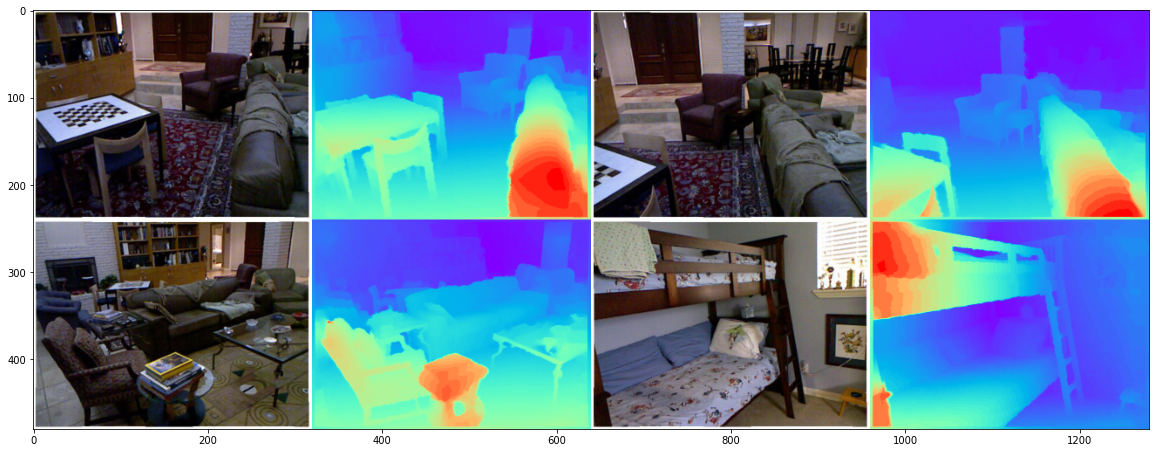

In [ ]:
def display_images(outputs=None, inputs=None, gt=None, is_colormap=True, is_rescale=True):

    rainbow = plt.get_cmap('rainbow')  # Color map for visualization 
    if gt is not None:
        inputs, outputs = gt.__getitem__(2)  
    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)

    all_images = []

    for i in range(outputs.shape[0]):
        imgs = []

        if isinstance(inputs, (list, tuple, np.ndarray)):
            x = inputs[i]
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True)
            imgs.append(x)

        if is_colormap:
            rescaled = outputs[i][:, :, 0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
            imgs.append(rainbow(rescaled)[:, :, :3])
        else:
            imgs.append(to_multichannel(outputs[i]))

        img_set = np.hstack(imgs)
        all_images.append(img_set)

    all_images = np.stack(all_images)

    return skimage.util.montage(all_images, multichannel=True, fill=(0, 0, 0))
    
viz = display_images(gt=train_generator)
plt.figure(figsize=(20,8))
plt.imshow(viz)
plt.show()


This model is an encoder-decoder network for depth estimation. 
For encoder, the input RGB image is encoded into a feature vector using
the [DenseNet-169 network](https://ieeexplore.ieee.org/document/8099726) pretrained on [ImageNet](https://image-net.org/about.php).

The decoder formed from these layers sequentially : 

1.   Convolutional 1 × 1 layer for the output of the encoder with number of features equal to number of features in encoder's final layer 
2.   Four continuous of **upsampling blocks** with their corresponding skip-connections.
3.   Convolutional 3 × 3 layer for the output of the encoder with number of features equal to 1 

Each upsmaple block contains the following layers:
1. Bilinear upsampling 2 × 2
2. Concatenate layer with layers from encoder 
3. Convolutional 3 × 3 layer with number of features equal to half of previous input's features block 
4. Convolutional 3 × 3 layer with number of features equal to half of previous input's features  block 


The following picture contains network architecture:


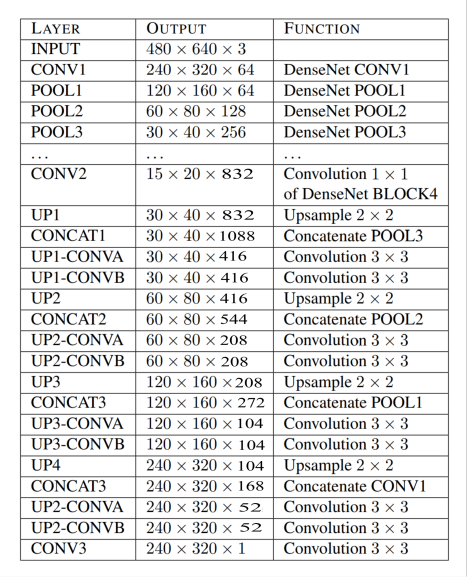


Names of important encoder layers to be used:
'pool3_pool'

'pool2_pool'

'pool1'

'conv1/relu'

In [ ]:
class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        if data_format is None:
            data_format = K.image_data_format()
        self.data_format = data_format.lower()
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],input_shape[1],height,width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],height,width,input_shape[3])

    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None

        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        

def create_model():
        print('Loading base model (DenseNet)..')
        # Encoder Layers

        base_model = applications.densenet.DenseNet169(input_shape=(None, None, 3), include_top=False)

        print('Base model loaded.')

        # Starting point for decoder
        base_model_output_shape = base_model.layers[-1].output.shape

        # Layer freezing?
        for layer in base_model.layers: layer.trainable = True

        # Starting number of decoder filters

        decode_filters = int(int(base_model_output_shape[-1]) / 2)

        # Define upsampling block 
        def upproject(tensor, filters, name, concat_with):
            up_i = BilinearUpSampling2D((2, 2), name=name + '_upsampling2d')(tensor)
            up_i = Concatenate(name=name + '_concat')([up_i, base_model.get_layer(concat_with).output])  # Skip connection
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name + '_convA')(up_i)
            up_i = LeakyReLU(alpha=0.2)(up_i)
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name + '_convB')(up_i)
            up_i = LeakyReLU(alpha=0.2)(up_i)
            return up_i

        #################################################################
        
        # Construct the decoder according to the table mentioned above

        conv2 = Conv2D(filters=decode_filters, kernel_size=1, strides=1, padding='same', name='decoder_conv2')(base_model.output)
        up_1 = upproject(conv2, decode_filters / 2, 'UP1', 'pool3_pool')
        up_2 = upproject(up_1, decode_filters / 4, 'UP2', 'pool2_pool')
        up_3 = upproject(up_2, decode_filters / 8, 'UP3', 'pool1')
        up_4 = upproject(up_3, decode_filters / 16, 'UP4', 'conv1/relu')
        conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='decoder_conv3')(up_4)
        #################################################################

        # Create the model
        model = Model(inputs=base_model.input, outputs=conv3)

        print('Model created.')

        return model

# Create the model
model = create_model()

Loading base model (DenseNet)..
Base model loaded.
Model created.


##Defining Hyperparameters

In [ ]:
learning_rate=0.0001
batch_size=20
epochs=10

# Where to set model logs and checkpoints (weights)
runID = str(int(time.time())) + '-n' + str(len(train_generator)) + '-e' + str(epochs) + '-bs' + str(batch_size) + '-lr' + str(learning_rate)
outputPath = '/content/drive/My Drive/models/'
runPath = outputPath + runID
pathlib.Path(runPath).mkdir(parents=True, exist_ok=True)
print('Output: ' + runPath)

Output: /content/drive/My Drive/models/1655237569-n108-e10-bs20-lr0.0001


# Loss Function
The overall loss function can be given in the following form:
$$L(y, \hat{y})=\lambda L_{\text {depth }}(y, \hat{y})+L_{\text {grad }}(y, \hat{y})+L_{S S I M}(y, \hat{y})$$

This loss function consists of three componenets:


*   $L_depth$ is a $L_1$ loss defined on the depth values



$$
L_{\text {depth }}(y, \hat{y})=\frac{1}{n} \sum_{p}^{n}\left|y_{p}-\hat{y}_{p}\right|
$$

*   $L_{grad}$ is the $L_1$ loss defined over the image gradient $g$ of the depth image
$$
L_{g r a d}(y, \hat{y})=\frac{1}{n} \sum_{p}^{n}\left|\boldsymbol{g}_{\mathbf{x}}\left(y_{p}, \hat{y}_{p}\right)\right|+\left|\boldsymbol{g}_{\mathbf{y}}\left(y_{p}, \hat{y}_{p}\right)\right|
$$
* $L_{SSIM}$ uses the Structural Similarity (SSIM) metric which is a commonly-used for image reconstruction tasks
$$
L_{S S I M}(y, \hat{y}) = \frac{1  - L_{S S I M}(y, \hat{y}) }{2}
$$

In [ ]:
def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0 / 10.0):


    #######################################################
    # Write the three loss functions l_depth, l_edges, l_ssim
    # there is a function for calculation ssim in tensor flow

    l_depth = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))
    # Depth smoothness
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y

    l_edges = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(abs(smoothness_y))
    l_ssim = tf.reduce_mean(1 - tf.image.ssim( y_true, y_pred, max_val=maxDepthVal, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2))

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta
    
    #######################################################
    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))


# Accuracy Metrics: 
There are several metrics that represent the accuracy for depth estimation task:


*   Average Relative Error
$$\frac{1}{n} \sum_{p}^{n} \frac{\left|y_{p}-\hat{y}_{p}\right|}{y}$$
*   Root Mean Squared Error




  $$ \sqrt{\left.\frac{1}{n} \sum_{p}^{n}\left(y_{p}-\hat{y}_{p}\right)^{2}\right)}$$
  * Average $log _{10}$ Error
  $$\frac{1}{n} \sum_{p}^{n}\left|\log _{10}\left(y_{p}\right)-\log _{10}\left(\hat{y}_{p}\right)\right|$$
  
  * Threshold Accuracy $\delta_{i}$ \% of $y_{p}$ so that
  $$\max \left(\frac{y_{p}}{\hat{y}_{p}}, \frac{\hat{y}_{p}}{y_{p}}\right)=\delta<\operatorname{thr} for \operatorname{thr}=1.25,1.25^{2}, 1.25^{3}
$$

In [ ]:
from numpy.ma.core import log10
def compute_errors(gt, pred):
    #######################################################
    # Write the accuracy functions mentioned above 

    rmse = np.sqrt(np.sum((gt - pred)**2) / len(gt))
    log_10 = np.sum(abs(log10(gt) - log10(pred))) / len(gt)

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    a1 = tf.keras.metrics.Accuracy(threshold=1.25).update_state(gt, pred)
    a2 = tf.keras.metrics.Accuracy(threshold=1.25**2).update_state(gt, pred)
    a3 = tf.keras.metrics.Accuracy(threshold=1.25**3).update_state(gt, pred)

    #######################################################
    return a1, a2, a3, abs_rel, rmse, log_10

# Train the network
The pipeline of training and evaluation 



### Predection Funciton
Apply the RGB image batch to the network

In [ ]:
def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)   # Model in Keras has a built-in function model.predict()
    # Put in expected range
    return np.clip(maxDepth / predictions, minDepth, maxDepth) / maxDepth

### Evaluation Function
Apply the evalution process based on accuracy metrics using the test dataset 

In [ ]:
def scale_up(scale, images):
    scaled = []
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append(resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True))
    return np.stack(scaled)

def evaluate(model, rgb, depth, crop, batch_size=6):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []

    for i in range(N // bs):
        x = rgb[(i) * bs:(i + 1) * bs, :, :, :]

        # Compute results
        true_y = depth[(i) * bs:(i + 1) * bs, :, :]
        pred_y = scale_up(2, predict(model, x / 255, minDepth=10, maxDepth=1000, batch_size=bs)[:, :, :, 0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:, crop[0]:crop[1] + 1, crop[2]:crop[3] + 1]
        pred_y = pred_y[:, crop[0]:crop[1] + 1, crop[2]:crop[3] + 1]

        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(pred_y[j])
            testSetDepths.append(true_y[j])

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
    print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0], e[1], e[2], e[3], e[4], e[5]))
    return e

### Training Process

Funcations (callbacks) to perform on the ending of the each epochs 

In [ ]:
def get_nyu_callbacks(model, train_generator, val_generator, test_set, runPath,do_eval):
    callbacks = []
    # Callback: Tensorboard
    class LRTensorBoard(keras.callbacks.TensorBoard):
        def __init__(self, log_dir):
            super().__init__(log_dir=log_dir)
            self.writer = tf.summary.create_file_writer(log_dir)

        def on_epoch_end(self, epoch, logs=None):
              # Metrics to calcaute when finishing each epoch 
              if do_eval:
                e = evaluate(model,test_set, batch_size)
                #######################################################
                # Write your own writer of accuracy metrics in Tensorboard
                # a1, a2, a3, abs_rel, rmse, log_10

                tf.summary.scalar('a1', data=e[0], step=epoch)
                tf.summary.scalar('a2', data=e[1], step=epoch)
                tf.summary.scalar('a3', data=e[2], step=epoch)
                tf.summary.scalar('abs_rel', data=e[3], step=epoch)
                tf.summary.scalar('rmse', data=e[4], step=epoch)
                tf.summary.scalar('log_10', data=e[5], step=epoch)

                #######################################################

              super().on_epoch_end(epoch, logs)

    callbacks.append(LRTensorBoard(log_dir=runPath))

    # Callback: Learning Rate Scheduler
    lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=0.00009,min_delta=1e-2)
    callbacks.append(lr_schedule)  # reduce learning rate when stuck

    return callbacks


Using Adam optimizer and applying the loss function

In [ ]:
optimizer = Adam(learning_rate=learning_rate, amsgrad=True)

model.compile(loss=depth_loss_function, optimizer=optimizer)  # Applying the optimizer and the loss function

callbacks = get_nyu_callbacks(model, train_generator, val_generator, test_set, runPath,do_eval=False) # Creating the callbacks 

model.fit(train_generator, callbacks=callbacks, validation_data=val_generator, epochs=epochs, shuffle=True)  # starting the training process


Epoch 1/10
108/108 [==============================] - 162s 1s/step - loss: 0.3805 - val_loss: 0.5702 - lr: 1.0000e-04
Epoch 2/10
108/108 [==============================] - 121s 1s/step - loss: 0.2402 - val_loss: 0.8029 - lr: 1.0000e-04
Epoch 3/10
108/108 [==============================] - 123s 1s/step - loss: 0.2178 - val_loss: 0.7571 - lr: 1.0000e-04
Epoch 4/10
108/108 [==============================] - 128s 1s/step - loss: 0.1985 - val_loss: 0.8411 - lr: 1.0000e-04
Epoch 5/10
108/108 [==============================] - 123s 1s/step - loss: 0.1851 - val_loss: 0.8566 - lr: 1.0000e-04
Epoch 6/10
108/108 [==============================] - 121s 1s/step - loss: 0.1691 - val_loss: 0.7457 - lr: 1.0000e-04
Epoch 7/10
108/108 [==============================] - 121s 1s/step - loss: 0.1575 - val_loss: 0.8014 - lr: 9.0000e-05
Epoch 8/10
108/108 [==============================] - 120s 1s/step - loss: 0.1497 - val_loss: 0.8303 - lr: 9.0000e-05
Epoch 9/10
108/108 [==============================] - 12

# Logging in Tensorboard
Show the training log and evalution metrics

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
%tensorboard --logdir '/content/drive/My Drive/models/1653931634-n108-e20-bs4-lr0.0001' #change based on your RunID

Reusing TensorBoard on port 6007 (pid 1160), started 0:24:09 ago. (Use '!kill 1160' to kill it.)

<IPython.core.display.Javascript object>

#Inferring on the Model


In [ ]:
def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)
inputs = load_images(glob.glob('/content/drive/My Drive/Datasets/ML_ITMO/data/examples/*.png'))

outputs = predict(model, inputs)

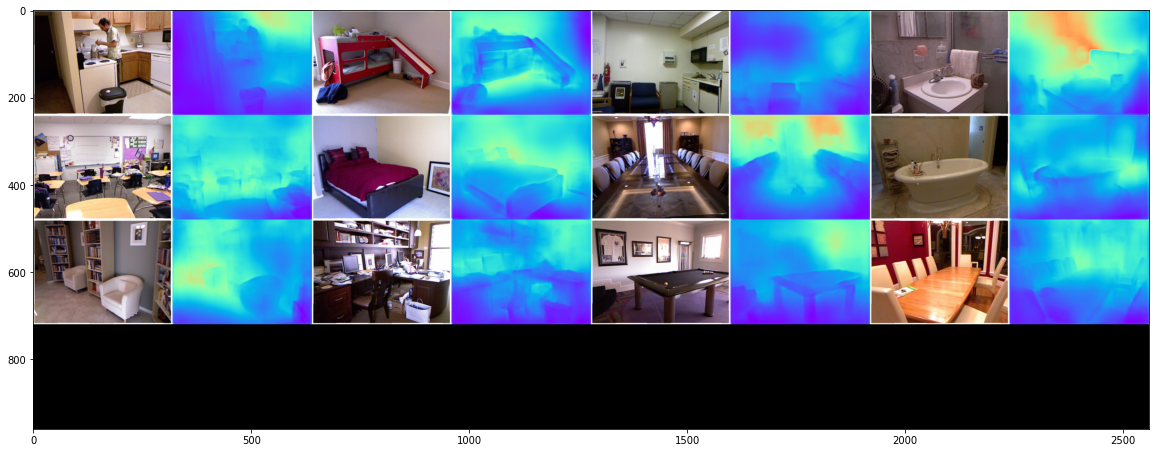

In [ ]:
viz = display_images(outputs=outputs.copy(), inputs=inputs.copy())
plt.figure(figsize=(20,20))
plt.imshow(viz)
plt.savefig('test.png')
plt.show()